Example of accounting for a "trivial" selection function in a likelihood function, but also inferring the density.

See also `Toy-selection-function-problem.ipynb`

In [4]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from scipy.special import erf

In [36]:
def S(x, a, b):
    _x = np.atleast_1d(x)
    return (_x < a) | (_x > b)

In [37]:
rng = np.random.default_rng(seed=42)

true_N = 8675
x = rng.normal(size=true_N)
ab = (-0.5, 0.2)
sel_x = x[S(x, *ab)]

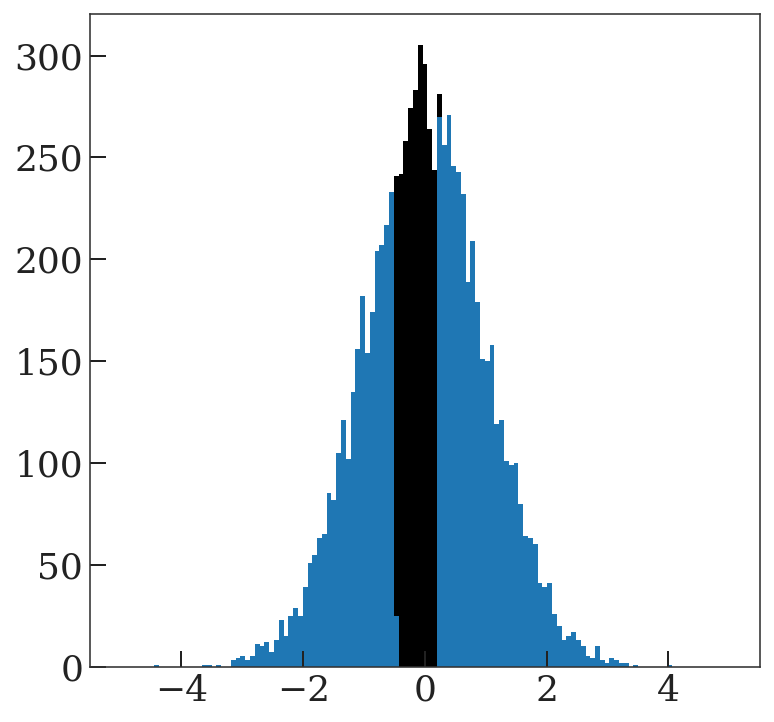

In [38]:
bins = np.linspace(-5, 5, 128)
plt.hist(x, bins=bins)
plt.hist(sel_x, bins=bins);

In [43]:
def ln_normal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)


def ln_likelihood(p, x):
    ln_n0, mu, lnstd = p
    std = np.exp(lnstd)
    return ln_normal(x, mu, std).sum() + x.size * ln_n0 - np.exp(ln_n0)


def ln_likelihood2(p, x, a, b):
    ln_n0, mu, lnstd = p
    std = np.exp(lnstd)
    
    # this is like the effective volume, Veff
    Veff = 0.5 * ((1 + erf((a - mu) / (np.sqrt(2) * std))) + 
                  (1 - erf((b - mu) / (np.sqrt(2) * std))))
    
    return (- np.exp(ln_n0) * Veff +
            x.size * ln_n0 + 
            ln_normal(x, mu, std).sum() + 
            np.log(S(x, *ab)).sum())

In [44]:
(ln_likelihood([np.log(true_N), 0, 0], x), 
 ln_likelihood([np.log(true_N), 0, 0], sel_x), 
 ln_likelihood2([np.log(true_N), 0, 0], sel_x, *ab))

(57684.660481772204, 38255.2542670489, 40603.769097985176)

In [45]:
bootstrap_K = 256
rng = np.random.default_rng(seed=123)

opt_ps = []
for k in range(bootstrap_K):
    xx = rng.choice(x, size=len(x))
    res = minimize(lambda *args: -ln_likelihood(*args), 
                   x0=[np.log(true_N), 0, 0], args=(xx, ), method='nelder-mead')
    opt_ps.append(res.x)
opt_ps = np.array(opt_ps)

# ---

sel_opt_ps = []
for k in range(bootstrap_K):
    xx = rng.choice(sel_x, size=len(sel_x))
    res = minimize(lambda *args: -ln_likelihood(*args), 
                   x0=[np.log(true_N), 0, 0], args=(xx, ), method='nelder-mead')
    sel_opt_ps.append(res.x)
sel_opt_ps = np.array(sel_opt_ps)

# ---

sel_opt_ps2 = []
for k in range(bootstrap_K):
    xx = rng.choice(sel_x, size=len(sel_x))
    res = minimize(lambda *args: -ln_likelihood2(*args), 
                   x0=[np.log(true_N), 0, 0], args=(xx, *ab), method='nelder-mead')
    sel_opt_ps2.append(res.x)
sel_opt_ps2 = np.array(sel_opt_ps2)

In [47]:
import corner

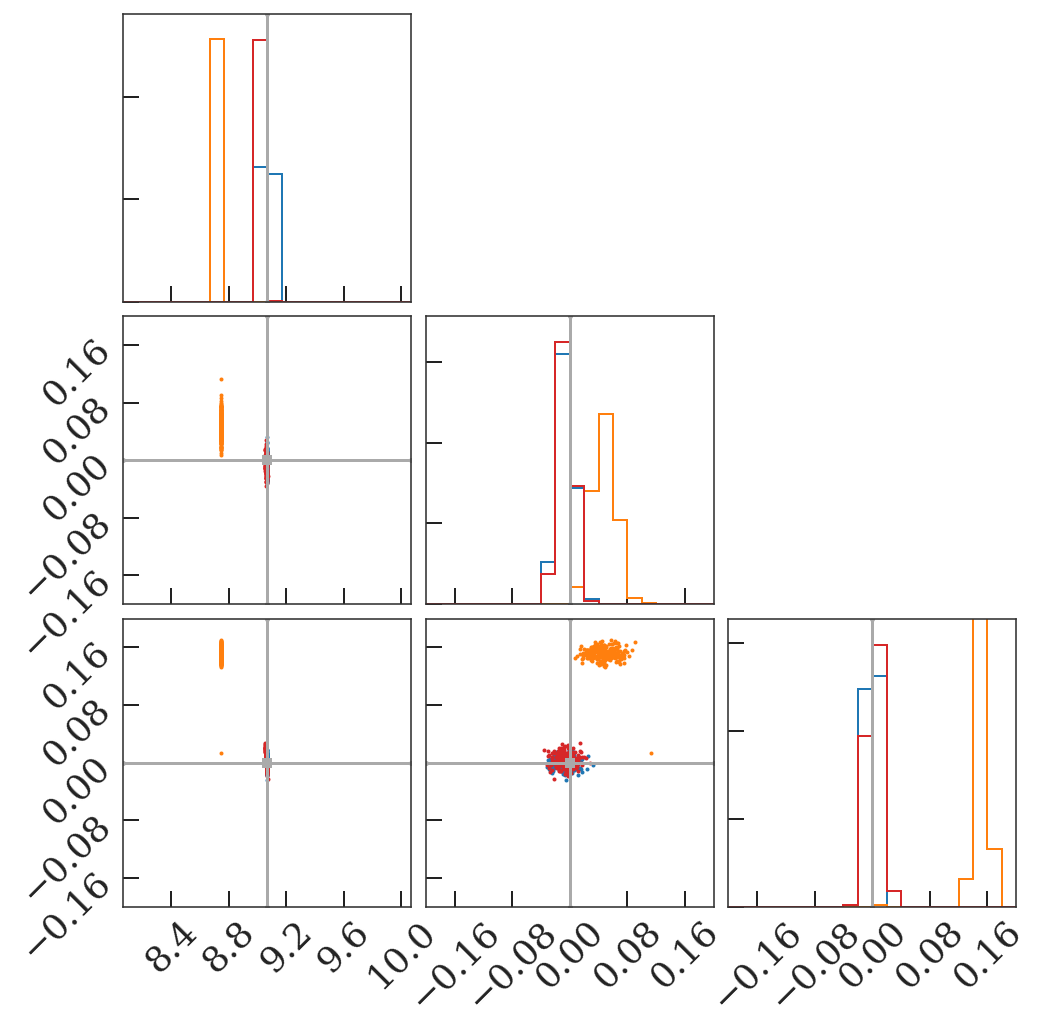

In [58]:
kw = dict(plot_contours=False, 
          plot_density=False,  
          data_kwargs=dict(alpha=1),
          range=[(np.log(true_N)-1, np.log(true_N)+1), (-0.2, 0.2), (-0.2, 0.2)])
fig = None
for vals, color in zip([opt_ps, sel_opt_ps, sel_opt_ps2], 
                       ['tab:blue', 'tab:orange', 'tab:red']):
    kw['data_kwargs']['color'] = color
    if fig is None:
        fig = corner.corner(vals, color=color, truths=[np.log(true_N), 0, 0], truth_color='#aaaaaa', **kw)
    else:
        corner.corner(vals, color=color, fig=fig, **kw)